## Airbnb cleaning script

script to clean the airbnb file downloaded from AirBNB, enriching with offical geographical data from the City of amsterdam (using offical WFS layers hosted at api.data.amsterdam.nl) 
Files are then stored for further analysis

In [26]:
%matplotlib inline
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gp
from shapely.geometry import Point, Polygon, MultiPolygon, LineString, MultiLineString

# helper functions
sys.path.insert(0, 'helper_functions/')
from logger_settings import logger
from wfs_processing import get_available_layers_from_wfs, get_layer_from_wfs
pd.set_option('display.max_columns', 100)

# data downloaded from http://insideairbnb.com/get-the-data.html
PATH_TO_DATA = '/home/diederik/ams/pyprojects/geospatial_analysis/data/'
AIR_BNB_FILE_SUMMARY = 'airbnb_ams_listings_summary.csv' # summary version
AIR_BNB_FILE_FULL = 'airbnb_ams_listings_full.csv' # summary version

# ams gebieden from WFS (). For full services see: https://api.data.amsterdam.nl/api/
url_wfs = 'https://map.data.amsterdam.nl/maps/gebieden'

In [2]:
# see what layers are available (see code in helper_functions section)
get_available_layers_from_wfs(url_wfs=url_wfs)

Mon, 06 Aug 2018 14:09:06 INFO     layername: buurt
Mon, 06 Aug 2018 14:09:06 INFO     layername: buurt_simple
Mon, 06 Aug 2018 14:09:06 INFO     layername: buurtcombinatie
Mon, 06 Aug 2018 14:09:06 INFO     layername: buurtcombinatie_simple
Mon, 06 Aug 2018 14:09:06 INFO     layername: gebiedsgerichtwerken
Mon, 06 Aug 2018 14:09:06 INFO     layername: stadsdeel
Mon, 06 Aug 2018 14:09:06 INFO     layername: bouwblok
Mon, 06 Aug 2018 14:09:06 INFO     layername: grootstedelijkgebied
Mon, 06 Aug 2018 14:09:06 INFO     layername: unesco
Mon, 06 Aug 2018 14:09:06 INFO     layername: buurt_label
Mon, 06 Aug 2018 14:09:06 INFO     layername: buurtcombinatie_label
Mon, 06 Aug 2018 14:09:06 INFO     layername: gebiedsgerichtwerken_label
Mon, 06 Aug 2018 14:09:06 INFO     layername: stadsdeel_label
Mon, 06 Aug 2018 14:09:06 INFO     layername: bouwblok_label
Mon, 06 Aug 2018 14:09:06 INFO     layername: grootstedelijkgebied_label
Mon, 06 Aug 2018 14:09:06 INFO     layername: unesco_label


['buurt',
 'buurt_simple',
 'buurtcombinatie',
 'buurtcombinatie_simple',
 'gebiedsgerichtwerken',
 'stadsdeel',
 'bouwblok',
 'grootstedelijkgebied',
 'unesco',
 'buurt_label',
 'buurtcombinatie_label',
 'gebiedsgerichtwerken_label',
 'stadsdeel_label',
 'bouwblok_label',
 'grootstedelijkgebied_label',
 'unesco_label']

In [3]:
# we will load in stadsdelen (boroughs), buurtcombinaties (districts) and buurten (neighbourhoods)
from wfs_processing import get_sd_layer, get_bc_layer, get_buurt_layer
sd = get_sd_layer()
buurt_combi = get_bc_layer()
buurt = get_buurt_layer()

Mon, 06 Aug 2018 14:09:06 INFO     Requesting data from https://map.data.amsterdam.nl/maps/gebieden, layer: stadsdeel
Mon, 06 Aug 2018 14:09:07 INFO     8 features returned.
Mon, 06 Aug 2018 14:09:07 INFO     Requesting data from https://map.data.amsterdam.nl/maps/gebieden, layer: buurtcombinatie
Mon, 06 Aug 2018 14:09:07 INFO     99 features returned.
Mon, 06 Aug 2018 14:09:07 INFO     Requesting data from https://map.data.amsterdam.nl/maps/gebieden, layer: buurt
Mon, 06 Aug 2018 14:09:09 INFO     481 features returned.


In [4]:
# load airbnb data
date_cols = ['last_review']
df= (pd.read_csv(PATH_TO_DATA + AIR_BNB_FILE_SUMMARY, parse_dates=date_cols, 
                 decimal = ',').dropna(how= 'all', axis=1))

df['price'] = df['price'].astype(float) 

df = df.rename(columns = {'longitude': 'lon', 'latitude': 'lat'})
# lon, lat to float
for col in ['lon', 'lat']:
    df[col] = df[col].astype(float)

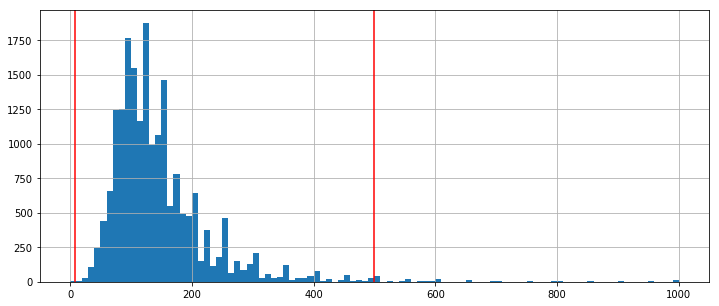

In [5]:
_, bins = pd.qcut(df['price'], q=[0.0001, 0.99], retbins=True)
ax = df['price'].hist(bins=100, range=(0,1000), figsize= [12,5])

for b in bins:
    ax.axvline(b, color='r')

In [6]:
# skim off the extreme prices (bins = array([ -10.,  455.]))
df = df[(df['price'] > bins[0]) & (df['price'] < bins[1])]

Text(0.5,1,'Emperical Distribution')

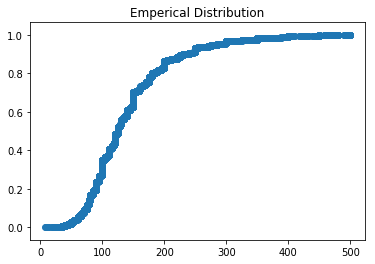

In [21]:
# let's viz the price
def ecdf(data):
    return np.sort(data), np.arange(1, len(data)+1) / len(data)

x, y = ecdf(df['price'])
plt.scatter(x,y)
plt.title('Emperical Distribution')

In [7]:
crs_initial = {'init': 'epsg:4326'} 
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
df = gp.GeoDataFrame(df, crs=crs_initial, geometry=geometry)
df = df.drop(['lon', 'lat'], axis=1)

# change to RD new Amersfoort
crs = {'init': 'epsg:28992'}
df = df.to_crs(crs=crs)

In [9]:
df.head(1)

,id,name,host_id,host_name,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,Private room,69.0,3,233,2018-06-24,2.06,1,116,POINT (124637.2554813915 486523.2381693435)


The Airbnb contains neighboordhood names that don't seem proper. Let's use the offical names  of the 'stadsdelen', 'wijken' and 'buurten' of the municipality of amsterdam as offered in their WFS geojsons. We merge the data back on the dataframe by applying spatial joins (intersect)

In [11]:
# add the stadsdelen
df = (gp.sjoin(df, sd[['geometry', 'sd_code', 'sd_name']], how='inner', op='intersects')
     .drop('index_right', axis=1))
print ('df shape after join with {}: {}'.format(sd.name, df.shape))

# add the districts
df = (gp.sjoin(df, buurt_combi, how='inner', op = 'intersects')
        .drop('index_right', axis=1))
print ('df shape after join with {}: {}'.format(buurt_combi.name, df.shape))

# add the neighbourhoods
df = (gp.sjoin(df, buurt, how='inner', op = 'intersects')
        .drop('index_right', axis=1))
print ('df shape after join with {}: {}'.format(buurt.name, df.shape))

df shape after join with stadsdelen: (19316, 16)
df shape after join with buurt_combinatie: (19316, 18)
df shape after join with buurt: (19316, 20)


In [19]:
# write to csv
df.to_csv(PATH_TO_DATA + 'airbnb_munged.csv', index=False)
sd.to_csv(PATH_TO_DATA + 'sd.csv', index=False)
buurt_combi.to_csv(PATH_TO_DATA + 'buurt_combi.csv', index=False)
buurt.to_csv(PATH_TO_DATA + 'buurt.csv', index=False)